## 通用爬虫代码

# 令人心动的offer2可视化分析

In [32]:
import pandas as pd
import numpy as np
import pyecharts.options as opts
from pyecharts.charts import *
from pyecharts.globals import ThemeType

## 批量导入数据并合并

In [33]:
# path = 'D:/Pandas/csv/'
# #文件目录路径
# df_all = pd.DataFrame()
# for i in os.listdir(path):
#     df_one = pd.read_csv(path+f'{i}', engine='python', encoding='utf-8')  
#     df_all = df_all.append(df_one, ignore_index=False)#ignore_index：默认值为False，如果为True则不使用index标签
# df_all.shape
# #输出
# df_all.to_excel('offer.xlsx',index=False)

## 数据读取

In [34]:
df = pd.read_excel('offer.xlsx')
df[:10]

,所属期数,用户id,弹幕,会员等级,发布时间,弹幕点赞,弹幕id
0,第1期,NaN,47，第一来了,4,5,23,6732257356663684096
1,第1期,NaN,第一,1,8,5,6732257393620750336
2,第1期,NaN,哈哈哈，我还以为我是第一个呢,1,7,32,6732257548063721472
3,第1期,NaN,YEYEYEY,0,8,16,6732257672952315904
4,第1期,NaN,来了来了，,6,6,18,6732258003787425792
5,第1期,叶湘伦,来了,0,8,0,6732258629720189952
6,第1期,NaN,来了来了,0,8,2,6732258673319944192
7,第1期,海浪,来啦,0,8,0,6732258806970479616
8,第1期,NaN,来咯,0,5,4,6732258885488543744
9,第1期,熙崽是神仙,第一！,0,7,9,6732260786762655744


## 数据处理及清洗

### 重命名

所属期数 episodes   用户id user     弹幕 comment    会员等级 grade  发布时间 date   弹幕点赞 likecounts     弹幕id dmid

In [35]:
df.rename(columns={'所属期数':'episodes','用户id':'user','弹幕':'comment','会员等级':'grade','发布时间':'date','弹幕点赞':'likecounts','弹幕id':'dmid'},inplace=True)
df.head()

,episodes,user,comment,grade,date,likecounts,dmid
0,第1期,NaN,47，第一来了,4,5,23,6732257356663684096
1,第1期,NaN,第一,1,8,5,6732257393620750336
2,第1期,NaN,哈哈哈，我还以为我是第一个呢,1,7,32,6732257548063721472
3,第1期,NaN,YEYEYEY,0,8,16,6732257672952315904
4,第1期,NaN,来了来了，,6,6,18,6732258003787425792


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70798 entries, 0 to 70797
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   episodes    70798 non-null  object
 1   user        26409 non-null  object
 2   comment     70797 non-null  object
 3   grade       70798 non-null  int64 
 4   date        70798 non-null  int64 
 5   likecounts  70798 non-null  int64 
 6   dmid        70798 non-null  int64 
dtypes: int64(4), object(3)
memory usage: 3.8+ MB


### 过滤字段

In [37]:
#对用户进行空值补充
df['user'] = df['user'].fillna('未知用户')
#对弹幕进行re匹配处理
df['comment'] = df['comment'].str.extract(r"([\u4e00-\u9fa5]+)") #提取中文内容
df = df.dropna()  #纯表情弹幕直接删除
#提取分析字段
df = df.iloc[:,:-1]
df.head()

,episodes,user,comment,grade,date,likecounts
0,第1期,未知用户,第一来了,4,5,23
1,第1期,未知用户,第一,1,8,5
2,第1期,未知用户,哈哈哈,1,7,32
4,第1期,未知用户,来了来了,6,6,18
5,第1期,叶湘伦,来了,0,8,0


### 时间格式转换

In [38]:
def time_change(seconds):
    m, s = divmod(seconds, 60)
    h, m = divmod(m, 60)
    ss_time = "%d:%02d:%02d" % (h, m, s)
    # print(ss_time)
    return ss_time
# time_change(seconds=8888)
#将time_change函数应用于date字段：
df["date"] = df["date"].apply(time_change)
#设置为需要的时间格式
df['date'] = pd.to_datetime(df['date'])
df['date'] = df['date'].apply(lambda x : x.strftime('%H:%M:%S'))

### 机械压缩函数处理comment

In [39]:
#定义机械压缩函数
def yasuo(st):
    for i in range(1,int(len(st)/2)+1):
        for j in range(len(st)):
            if st[j:j+i] == st[j+i:j+2*i]:
                k = j + i
                while st[k:k+i] == st[k+i:k+2*i] and k<len(st):   
                    k = k + i
                st = st[:j] + st[k:]    
    return st
# yasuo(st='')
#调用机械压缩函数
df["comment"] = df["comment"].astype("str").apply(yasuo)

### 会员等级打标

In [40]:
df.grade.value_counts().index.tolist()

[0, 3, 1, 4, 2, 5, 6, 7, 8]

In [41]:
df['grade'] = 'v'+df['grade'].astype('str')#['v'+i for i in df['grade']]

In [42]:
df.sample(2)

,episodes,user,comment,grade,date,likecounts
9235,第1期,未知用户,王颖飞好像一个演员,v0,00:27:42,5
57421,面试篇,zxz,彩虹袜,v3,00:13:07,12


## 数据分析

In [43]:
#绘图通用函数
def get_pyechart(x,y,chart,title,size,pos,theme):
    if chart == 'bar':
        c = (
            Bar(init_opts=opts.InitOpts(theme=theme))
            .add_xaxis(x)
            .add_yaxis("",y) 
            .set_series_opts(label_opts=opts.LabelOpts(font_size=size,position=pos))
            )
    elif chart == 'barh':
        c = (
            Bar(init_opts=opts.InitOpts(theme=theme))
            .add_xaxis(x)
            .add_yaxis("",y).reversal_axis() #X轴与y轴调换顺序
            .set_series_opts(label_opts=opts.LabelOpts(font_size=size,position=pos))
            )
    elif chart == 'pie':
        c = (
            Pie(init_opts=opts.InitOpts(theme=theme))
            .add("", list(zip(x,y)))
            .set_series_opts(label_opts=opts.LabelOpts(formatter="等级{b}占比:{d}%",font_size=size))
            )
    elif chart == 'line':
        c = (
            Line(init_opts=opts.InitOpts(theme=theme))
            .add_xaxis(x)
            .add_yaxis('情感倾向',y, is_smooth=True,is_connect_nones=True,areastyle_opts=opts.AreaStyleOpts(opacity=0.5))
            .set_global_opts(title_opts=opts.TitleOpts(title=title,subtitle="数据来源：腾讯视频",pos_left = 'left'))
            )
    c.set_global_opts(title_opts=opts.TitleOpts(title=title,subtitle="数据来源：腾讯视频",pos_left = 'left'),
                        xaxis_opts=opts.AxisOpts(axislabel_opts=opts.LabelOpts(font_size=13)), #更改横坐标字体大小
                        yaxis_opts=opts.AxisOpts(axislabel_opts=opts.LabelOpts(font_size=13)), #更改纵坐标字体大小
                        )
    return c.render_notebook()

### 1.各期弹幕数量对比

In [44]:
df_e = df['episodes'].value_counts()
df_e

面试篇    18603
第3期    18107
第1期    17551
第2期    15844
Name: episodes, dtype: int64

In [45]:
x = df_e.index.tolist()
y = df_e.values.tolist()
df_e = get_pyechart(x=x,y=y,chart='bar',title='各期弹幕数量',size=16,pos='top',theme=ThemeType.DARK)
df_e

#绘图
c = (
    Bar(init_opts=opts.InitOpts(theme=ThemeType.DARK))
    .add_xaxis(x)
    .add_yaxis("",y) 
    .set_global_opts(title_opts=opts.TitleOpts(title="各期弹幕数量",subtitle="数据来源：腾讯视频",pos_left = 'left'),
                       xaxis_opts=opts.AxisOpts(axislabel_opts=opts.LabelOpts(font_size=13)), #更改横坐标字体大小
                       yaxis_opts=opts.AxisOpts(axislabel_opts=opts.LabelOpts(font_size=13)), #更改纵坐标字体大小
                       )
    .set_series_opts(label_opts=opts.LabelOpts(font_size=16,position='top'))
    )
c.render_notebook()

### 2.谁是弹幕发射机

In [46]:
df_u = df['user'].value_counts()[1:10].sort_values(ascending=True)
df_u

神马不是浮云     78
.          79
圣雪天使       80
。          89
白龙吟        92
为时不晚i      93
momo       93
ベ☆小强呐     103
想太多de猫    135
Name: user, dtype: int64

In [47]:
x = df_u.index.tolist()
y = df_u.values.tolist()
df_u = get_pyechart(x=x,y=y,chart='barh',title='弹幕发送数量TOP10',size=16,pos='right',theme=ThemeType.DARK)
df_u

c = (
    Bar(init_opts=opts.InitOpts(theme=theme))
    .add_xaxis(x)
    .add_yaxis("",y).reversal_axis() #X轴与y轴调换顺序
    .set_global_opts(title_opts=opts.TitleOpts(title=title,subtitle="数据来源：腾讯视频",pos_left = 'left'),
                       xaxis_opts=opts.AxisOpts(axislabel_opts=opts.LabelOpts(font_size=13)), #更改横坐标字体大小
                       yaxis_opts=opts.AxisOpts(axislabel_opts=opts.LabelOpts(font_size=13)), #更改纵坐标字体大小
                       )
    .set_series_opts(label_opts=opts.LabelOpts(font_size=size,position='right'))
    )
c.render_notebook()

In [48]:
df[df["user"]=="想太多de猫"].sample(10)

,episodes,user,comment,grade,date,likecounts
17104,第1期,想太多de猫,爱吃辣的都是美女,v4,00:51:54,9
20881,第2期,想太多de猫,如果这都是咸鱼,v4,00:09:45,10
1489,第1期,想太多de猫,领带神马的太高端,v4,00:04:42,12
5408,第1期,想太多de猫,谦虚不等于诚实哦,v4,00:15:49,12
57919,面试篇,想太多de猫,大多数父母的想法,v4,00:14:54,7
60506,面试篇,想太多de猫,越看越自卑,v4,00:21:36,13
45714,第3期,想太多de猫,这是绝对的高质量对抗,v0,00:37:00,2
21397,第2期,想太多de猫,瞿泽林这句对人性的关怀,v4,00:11:05,49
59906,面试篇,想太多de猫,假发了解一下,v4,00:19:53,13
39564,第3期,想太多de猫,个人觉得直接问更好,v0,00:21:49,1


### 3.会员等级分布

In [49]:
df_g = df['grade'].value_counts().sort_values(ascending=True)
df_g

v8       12
v7      135
v6     1496
v5     2097
v2     2499
v4     2957
v1     3220
v3     3403
v0    54286
Name: grade, dtype: int64

In [50]:
x = df_g.index.tolist()
y = df_g.values.tolist()
df_g = get_pyechart(x=x,y=y,chart='pie',title='会员等级分布',size=14,pos='right',theme=ThemeType.DARK)
df_g

## 词云图讨论

In [51]:
import stylecloud
import jieba
import os 
from IPython.display import Image # 用于在jupyter lab中显示本地图

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\ADMINI~1\AppData\Local\Temp\jieba.cache
Loading model cost 2.044 seconds.
Prefix dict has been built successfully.


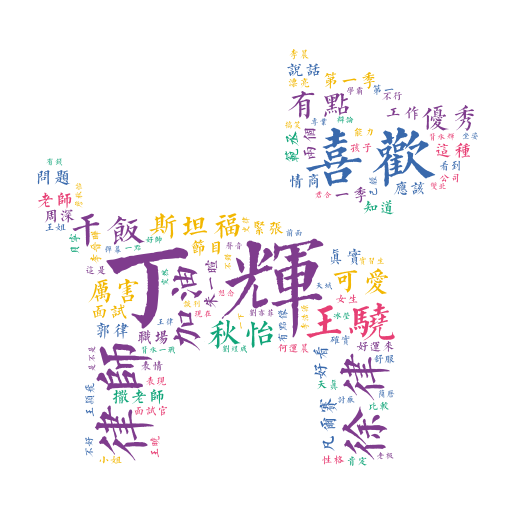

In [52]:
# 定义分词函数
def get_cut_words(content_series):
    # 读入停用词表
    stop_words = [] 
    with open(r"D:/Pandas/已学习/如何制作stylecloud词云？/stop_words.txt", 'r', encoding='utf-8') as f:
        lines = f.readlines()
        for line in lines:
            stop_words.append(line.strip())
    # 添加关键词
    my_words = ['撒老师', '范丞丞','第一季']  
    for i in my_words:
        jieba.add_word(i) 
    # 自定义停用词
    my_stop_words = ['好像', '真的','感觉']   
    stop_words.extend(my_stop_words)               
    # 分词
    word_num = jieba.lcut(content_series.str.cat(sep='。'), cut_all=False)
    # 条件筛选
    word_num_selected = [i for i in word_num if i not in stop_words and len(i)>=2]
    return word_num_selected
# 绘制词云图
text1 = get_cut_words(content_series=df['comment'])
stylecloud.gen_stylecloud(text=' '.join(text1), max_words=100,
                          collocations=False,
                          font_path='字酷堂清楷体.ttf',
                          icon_name='fas fa-dog',
                          size=512,
                          #palette='matplotlib.Inferno_9',
                          output_name='offer.png')
Image(filename='offer.png')

### 4.人物被提及

丁辉,詹秋怡,王骁,朱一暄,瞿泽林,李晋晔,王颖飞,刘煜成

In [53]:
#df.str.contains('')虽然不能用来判断，但是可以进行聚合操作
df_talk = ['丁辉','詹秋怡','王骁','朱一暄','瞿泽林','李晋晔','王颖飞','刘煜成']
dft = [df['comment'].str.contains(i).sum() for i in df_talk]
df_t = pd.DataFrame(data={'people':df_talk,'count':dft})
df_t = df_t.sort_values('count',ascending=False)
x = df_t['people'].tolist()
y = df_t['count'].tolist()
df_t = get_pyechart(x=x,y=y,chart='bar',title='被提及次数',size=16,pos='top',theme=ThemeType.DARK)
df_t

## 情感分析

In [61]:
import paddlehub as hub
#这里使用了百度开源的成熟NLP模型来预测情感倾向
senta = hub.Module(name="senta_bilstm")
texts = df['comment'].tolist()
input_data = {'text':texts}
res = senta.sentiment_classify(data=input_data)
df['pos'] = [x['positive_probs'] for x in res]
#重采样至15分钟
df.index = pd.to_datetime(df['date'])
data = df.resample('15min').mean().reset_index()

# #给数据表添加调色板
# import seaborn as sns
# color_map = sns.light_palette('orange', as_cmap=True)  #light_palette调色板
# data.style.background_gradient(color_map)

[2020-12-22 16:27:46,410] [    INFO] - Installing senta_bilstm module
[2020-12-22 16:27:46,436] [    INFO] - Module senta_bilstm already installed in C:\Users\Administrator\.paddlehub\modules\senta_bilstm
[2020-12-22 16:27:57,111] [    INFO] - Installing lac module
[2020-12-22 16:27:57,579] [    INFO] - Module lac already installed in C:\Users\Administrator\.paddlehub\modules\lac


In [ ]:
df[:10]

In [62]:
x = data["date"].to_list()
y = list(data["pos"].round(2))
df_p = get_pyechart(x=x,y=y,chart='line',title='情感倾向',size=16,pos='top',theme=ThemeType.DARK)
df_p